# Defininitions

In [1]:
import tarfile
import nibabel as nib

import matplotlib.pyplot as plt
import os 
from dotenv import load_dotenv
import numpy as np
import torch
import torch.nn as nn


dotenv_path = "../.env"
# Load environment variables from the specified .env file
load_dotenv(dotenv_path)

TRAIN_PATH = os.getenv("INPUT_MRI_DIR")
PROCESSED_PATH = os.getenv('PROCESSED_DATA_DIR')

In [20]:
def untar_brats(path):
    tar = tarfile.open(path)
    tar.extractall('../data/raw/train')
    tar.close()

def load_all_levels(file_path):
    levels = ['t1','flair','t2','t1ce']
    images = []
    try:
        images.append([nib.load(os.path.join(file_path,os.path.basename(file_path) +'_'+level+'.nii.gz')).get_fdata(dtype=np.float32).T for level in levels])
        images.append(nib.load(os.path.join(file_path, os.path.basename(file_path) +'_seg.nii.gz')).get_fdata(dtype=np.float64).T)
    except Exception as e:
        print(e)

    return images


def preprocess_nii_image(img_data, mean_norm=False):

    # Calculate the 99.5th percentile value
    percentile_99_5 = np.percentile(img_data, 99.5)
    # Rescale intensities by dividing them by the 99.5th percentile value
    img_data_ = img_data / percentile_99_5

    # Normalize the image data to have zero mean and unit variance
    if(mean_norm):
        mean = np.mean(img_data_)
        std_dev = np.std(img_data_)
        img_data_= (img_data_ - mean) / std_dev

    return img_data_




def plot_brain_sections(images,ax = 1,slice_index = 90):

    """ 
    slice_index = 130
    n_index = 4
    ax = 1 

    slice_index = 50
    n_index = 4
    ax = 2
    """

    d1,d2,d3 = np.shape(images[1])
    dims = [d1,d2,d3]
    dims.pop(ax)
    color_segmentation = np.zeros((dims[0],dims[1],3))


    gray_segmentation = np.take(images[1],slice_index,axis = ax)
    color_segmentation[gray_segmentation == 1] = [255,0,0] # Red (necrotic tumor core)
    color_segmentation[gray_segmentation == 2] = [0,255,0] # Green (peritumoral edematous/invaded tissue)
    color_segmentation[gray_segmentation == 4] = [0,0,255] # Blue (enhancing tumor)

    t1 = images[0][0]
    flair = images[0][1]
    t2 = images[0][2]
    t1ce = images[0][3]

    image = t1+t2+flair+t1ce

    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.imshow(np.take(image,slice_index,axis = 0),cmap='gray')



    plt.subplot(1,4,2)
    plt.imshow(np.take(image,slice_index,axis = 1),cmap='gray')



    plt.subplot(1,4,3)
    plt.imshow(np.take(image,slice_index,axis = 2),cmap='gray')

    plt.subplot(1,4,4)
    plt.imshow(color_segmentation,cmap='gray')
    plt.xlabel('Segmentation')

   #t1 = np.take(images[0][0],slice_index,axis = ax)
   #flair = np.take(images[0][1],slice_index,axis = ax)
   #t2 = np.take(images[0][2],slice_index,axis = ax)
   #t1ce = np.take(images[0][3],slice_index,axis = ax)

    #plt.figure(figsize=(20,10))
    #plt.subplot(1,5,1)
    #plt.imshow(t1,cmap='gray')
    #plt.xlabel('T1')
    #plt.subplot(1,5,2)
    #plt.imshow(flair,cmap='gray')
    #plt.xlabel('Flair')
    #plt.subplot(1,5,3)
    #plt.imshow(t2,cmap='gray')
    #plt.xlabel('T2')
    #plt.subplot(1,5,4)
    #plt.imshow(t1ce,cmap='gray')
    #plt.xlabel('T1CE')
    #plt.subplot(1,5,5)
    #plt.imshow(color_segmentation,cmap='gray')
    #plt.xlabel('Segmentation')
    #plt.show()

## UNET

In [ ]:
# Copyright (c) 2022, NVIDIA CORPORATION. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
import torch
import torch.nn as nn

normalizations = {
    "instancenorm3d": nn.InstanceNorm3d,
    "instancenorm2d": nn.InstanceNorm2d,
    "batchnorm3d": nn.BatchNorm3d,
    "batchnorm2d": nn.BatchNorm2d,
}

convolutions = {
    "Conv2d": nn.Conv2d,
    "Conv3d": nn.Conv3d,
    "ConvTranspose2d": nn.ConvTranspose2d,
    "ConvTranspose3d": nn.ConvTranspose3d,
}


def get_norm(name, out_channels, groups=32):
    if "groupnorm" in name:
        return nn.GroupNorm(groups, out_channels, affine=True)
    return normalizations[name](out_channels, affine=True)


def get_conv(in_channels, out_channels, kernel_size, stride, dim=3, bias=False):
    conv = convolutions[f"Conv{dim}d"]
    padding = get_padding(kernel_size, stride)
    return conv(in_channels, out_channels, kernel_size, stride, padding, bias=bias)


def get_transp_conv(in_channels, out_channels, kernel_size, stride, dim):
    conv = convolutions[f"ConvTranspose{dim}d"]
    padding = get_padding(kernel_size, stride)
    output_padding = get_output_padding(kernel_size, stride, padding)
    return conv(in_channels, out_channels, kernel_size, stride, padding, output_padding, bias=True)


def get_padding(kernel_size, stride):
    kernel_size_np = np.atleast_1d(kernel_size)
    stride_np = np.atleast_1d(stride)
    padding_np = (kernel_size_np - stride_np + 1) / 2
    padding = tuple(int(p) for p in padding_np)
    return padding if len(padding) > 1 else padding[0]


def get_output_padding(kernel_size, stride, padding):
    kernel_size_np = np.atleast_1d(kernel_size)
    stride_np = np.atleast_1d(stride)
    padding_np = np.atleast_1d(padding)
    out_padding_np = 2 * padding_np + stride_np - kernel_size_np
    out_padding = tuple(int(p) for p in out_padding_np)
    return out_padding if len(out_padding) > 1 else out_padding[0]


class InputBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(InputBlock, self).__init__()
        self.conv1 = get_conv(in_channels, out_channels, 3, 1)
        self.conv2 = get_conv(out_channels, out_channels, 3, 1)
        self.norm = get_norm(kwargs["norm"], out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x


class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, **kwargs):
        super(ConvLayer, self).__init__()
        self.conv = get_conv(in_channels, out_channels, kernel_size, stride)
        self.norm = get_norm(kwargs["norm"], in_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.norm(x)
        x = self.conv(x)
        x = self.relu(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv1 = ConvLayer(in_channels, out_channels, kernel_size, stride, **kwargs)
        self.conv2 = ConvLayer(out_channels, out_channels, kernel_size, 1, **kwargs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, **kwargs):
        super(UpsampleBlock, self).__init__()
        self.conv_block = ConvBlock(out_channels + in_channels, out_channels, kernel_size, 1, **kwargs)

    def forward(self, x, x_skip):
        x = nn.functional.interpolate(x, scale_factor=2, mode="trilinear", align_corners=True)
        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x


class OutputBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dim):
        super(OutputBlock, self).__init__()
        self.conv = get_conv(in_channels, out_channels, kernel_size=1, stride=1, dim=dim, bias=True)

    def forward(self, input_data):
        return self.conv(input_data)


class UNet3D(nn.Module):
    def __init__(
        self,
        kernels,
        strides,
    ):
        super(UNet3D, self).__init__()
        self.dim = 3
        self.n_class = 3
        self.deep_supervision = True
        self.norm = "instancenorm3d"
        self.filters = [64, 128, 256, 512, 768, 1024, 2048][: len(strides)]

        down_block = ConvBlock
        self.input_block = InputBlock(5, self.filters[0], norm=self.norm)
        self.downsamples = self.get_module_list(
            conv_block=down_block,
            in_channels=self.filters[:-1],
            out_channels=self.filters[1:],
            kernels=kernels[1:-1],
            strides=strides[1:-1],
        )
        self.bottleneck = self.get_conv_block(
            conv_block=down_block,
            in_channels=self.filters[-2],
            out_channels=self.filters[-1],
            kernel_size=kernels[-1],
            stride=strides[-1],
        )
        self.upsamples = self.get_module_list(
            conv_block=UpsampleBlock,
            in_channels=self.filters[1:][::-1],
            out_channels=self.filters[:-1][::-1],
            kernels=kernels[1:][::-1],
            strides=strides[1:][::-1],
        )
        self.output_block = self.get_output_block(decoder_level=0)
        self.deep_supervision_heads = self.get_deep_supervision_heads()
        self.apply(self.initialize_weights)

    def forward(self, input_data):
        out = self.input_block(input_data)
        encoder_outputs = [out]
        for downsample in self.downsamples:
            out = downsample(out)
            encoder_outputs.append(out)
        out = self.bottleneck(out)
        decoder_outputs = []
        for upsample, skip in zip(self.upsamples, reversed(encoder_outputs)):
            out = upsample(out, skip)
            decoder_outputs.append(out)
        out = self.output_block(out)
        if self.training and self.deep_supervision:
            out = [out]
            for i, decoder_out in enumerate(decoder_outputs[-3:-1][::-1]):
                out.append(self.deep_supervision_heads[i](decoder_out))
        return out

    def get_conv_block(self, conv_block, in_channels, out_channels, kernel_size, stride, drop_block=False):
        return conv_block(
            dim=self.dim,
            stride=stride,
            norm=self.norm,
            kernel_size=kernel_size,
            in_channels=in_channels,
            out_channels=out_channels,
        )

    def get_output_block(self, decoder_level):
        return OutputBlock(in_channels=self.filters[decoder_level], out_channels=self.n_class, dim=self.dim)

    def get_deep_supervision_heads(self):
        return nn.ModuleList([self.get_output_block(1), self.get_output_block(2)])

    def get_module_list(self, in_channels, out_channels, kernels, strides, conv_block):
        layers = []
        for in_channel, out_channel, kernel, stride in zip(in_channels, out_channels, kernels, strides):
            conv_layer = self.get_conv_block(conv_block, in_channel, out_channel, kernel, stride)
            layers.append(conv_layer)
        return nn.ModuleList(layers)

    def initialize_weights(self, module):
        name = module.__class__.__name__.lower()
        if name in ["conv2d", "conv3d"]:
            nn.init.kaiming_normal_(module.weight)
        if hasattr(module, "bias") and module.bias is not None:
            nn.init.constant_(module.bias, 0)






# Copyright (c) 2021-2022, NVIDIA CORPORATION. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch.nn as nn
from monai.losses import DiceCELoss, DiceFocalLoss, DiceLoss, FocalLoss


class Loss(nn.Module):
    def __init__(self, focal):
        super(Loss, self).__init__()
        if focal:
            self.loss_fn = DiceFocalLoss(
                include_background=False, softmax=True, to_onehot_y=True, batch=True, gamma=2.0
            )
        else:
            self.loss_fn = DiceCELoss(include_background=False, softmax=True, to_onehot_y=True, batch=True)

    def forward(self, y_pred, y_true):
        return self.loss_fn(y_pred, y_true)


class LossBraTS(nn.Module):
    def __init__(self, focal):
        super(LossBraTS, self).__init__()
        self.dice = DiceLoss(sigmoid=True, batch=True)
        self.ce = FocalLoss(gamma=2.0, to_onehot_y=False) if focal else nn.BCEWithLogitsLoss()

    def _loss(self, p, y):
        return self.dice(p, y) + self.ce(p, y.float())

    def forward(self, p, y):
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        p_wt, p_tc, p_et = p[:, 0].unsqueeze(1), p[:, 1].unsqueeze(1), p[:, 2].unsqueeze(1)
        l_wt, l_tc, l_et = self._loss(p_wt, y_wt), self._loss(p_tc, y_tc), self._loss(p_et, y_et)
        return l_wt + l_tc + l_et


# Visualize

In [ ]:
# Run only if not extracted
#untar_brats('../data/raw/BraTS2021_Training_Data.tar')

In [ ]:
files = os.listdir(TRAIN_PATH)
file_path = os.path.join(TRAIN_PATH,files[0])
images = load_all_levels(file_path)

#plot_brain_sections(images)



# Train

In [25]:

class CNN4Channel(nn.Module):
    def __init__(self):
        super(CNN4Channel, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 38 * 60 * 60, 120)
        self.fc2 = nn.Linear(120, 4)  # Adjust 10 to your desired output classes
        self.float()

    def forward(self, x):
        print(x.shape)
        x = torch.relu(self.conv1(x))
        print(x.shape)
        x = self.pool(x)
        print(x.shape)
        x = torch.relu(self.conv2(x))
        print(x.shape)
        x = self.pool(x)
        print(x.shape)
        x = x.view(-1, 32 * 38 * 60 * 60)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch.nn as nn
from monai.losses import DiceCELoss, DiceFocalLoss, DiceLoss, FocalLoss


class Loss(nn.Module):
    def __init__(self, focal):
        super(Loss, self).__init__()
        if focal:
            self.loss_fn = DiceFocalLoss(
                include_background=False, softmax=True, to_onehot_y=True, batch=True, gamma=2.0
            )
        else:
            self.loss_fn = DiceCELoss(include_background=False, softmax=True, to_onehot_y=True, batch=True)

    def forward(self, y_pred, y_true):
        return self.loss_fn(y_pred, y_true)


class LossBraTS(nn.Module):
    def __init__(self, focal):
        super(LossBraTS, self).__init__()
        self.dice = DiceLoss(sigmoid=True, batch=True)
        self.ce = FocalLoss(gamma=2.0, to_onehot_y=False) if focal else nn.BCEWithLogitsLoss()

    def _loss(self, p, y):
        return self.dice(p, y) + self.ce(p, y.float())

    def forward(self, p, y):
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        p_wt, p_tc, p_et = p[:, 0].unsqueeze(1), p[:, 1].unsqueeze(1), p[:, 2].unsqueeze(1)
        l_wt, l_tc, l_et = self._loss(p_wt, y_wt), self._loss(p_tc, y_tc), self._loss(p_et, y_et)
        return l_wt + l_tc + l_et


In [178]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(4, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),

            # Add more convolution and pooling layers as needed

            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # Add more transposed convolution layers as needed

            nn.ConvTranspose3d(16, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output between 0 and 1 for image data
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [174]:
def padding(images):
    pad_list = images
    for i in range(0,len(images)): 
        for c in range(0,len(images[i])): 
            pad_list[i][c] = np.pad(images[i][c],[(0,85),(0,0),(0,0)],'constant')
    #np.argwhere(np.count_nonzero(imm,axis=0)).shape ==  np.argwhere(np.count_nonzero(impad,axis=0)).shape
    return pad_list



In [196]:
import glob
files = glob.glob(TRAIN_PATH+"/**")
batch_list = []
for el in files:

    file_path = os.path.join(TRAIN_PATH,el)
    images = load_all_levels(file_path)[0]
    batch_list.append(images)

batch_list = padding(batch_list)
train_data = np.asarray(batch_list)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, num_workers=2)


In [199]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Initialize the model
autoencoder = Autoencoder().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)



# Training loop
autoencoder = autoencoder.to(torch.float)

autoencoder.train()
num_epochs = 1
for epoch in range(num_epochs):

    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        
        #images = torch.cat([el for el in data], dim=0)
        images = data
        optimizer.zero_grad()
        
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Using cpu device


torch.Size([2, 4, 240, 240, 240])
Epoch [1/2], Loss: 284380.8438
torch.Size([2, 4, 240, 240, 240])
Epoch [1/2], Loss: 239073.8281
torch.Size([2, 4, 240, 240, 240])
Epoch [2/2], Loss: 284338.9688
torch.Size([2, 4, 240, 240, 240])
Epoch [2/2], Loss: 239055.5156


In [215]:
autoencoder.eval()
out = autoencoder(list(enumerate(train_loader))[0][1])


In [216]:
out.shape

torch.Size([2, 4, 240, 240, 240])

In [229]:
o = out.T.detach().numpy()

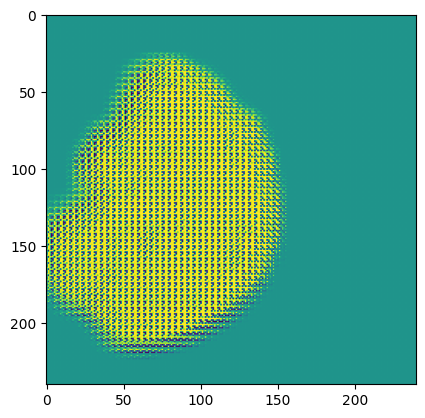

In [232]:
plt.imshow(o[100,:,:,0,0])

In [ ]:
from monai import transforms

def threshold(x):
    return x > 0.0


def calculate_pad_shape(image):
    min_shape = [128,128,128]
    image_shape = image.shape[1:]
    if len(min_shape) == 2:  # In 2D case we don't want to pad depth axis.
        min_shape.insert(0, image_shape[0])
    pad_shape = [max(mshape, ishape) for mshape, ishape in zip(min_shape, image_shape)]
    return pad_shape


def pad(image, padding):
    pad_d, pad_w, pad_h = padding
    return np.pad(
        image,
        (
            (0, 0),
            (math.floor(pad_d), math.ceil(pad_d)),
            (math.floor(pad_w), math.ceil(pad_w)),
            (math.floor(pad_h), math.ceil(pad_h)),
        ),
    )

In [ ]:
np.shape(images[0])

In [ ]:
files = os.listdir(TRAIN_PATH)[:10]
for el in files:
    file_path = os.path.join(TRAIN_PATH,el)
    images = load_all_levels(file_path)
    image = images[0][0]
    #bbox = transforms.utils.generate_spatial_bounding_box(image)
    #image_crop = transforms.SpatialCrop(roi_start=bbox[0], roi_end=bbox[1])(image)
    image_crop = CropForeground(select_fn=threshold, margin=0)(image)
    print(image_crop.shape)

    pp = calculate_pad_shape(image_crop)
    print(pp)
    #image_norm = transforms.NormalizeIntensity(image_crop,nonzero=nonzero, channel_wise=True)(image_crop)
    #print(np.amax(image_norm),np.amax(image))

## Image histogram

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.hist(t1)
plt.xlabel('T1')
plt.subplot(1,4,2)
plt.hist(flair)
plt.xlabel('Flair')
plt.subplot(1,4,3)
plt.hist(t2)
plt.xlabel('T2')
plt.subplot(1,4,4)
plt.hist(t1ce)
plt.xlabel('T1CE')
plt.show()